In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\train\millitary\millitary_0_8543.jpeg
Image class: millitary
Image height: 256
Image width: 256


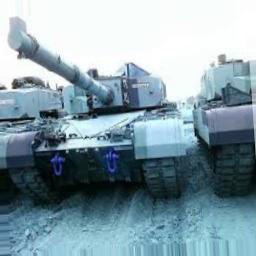

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

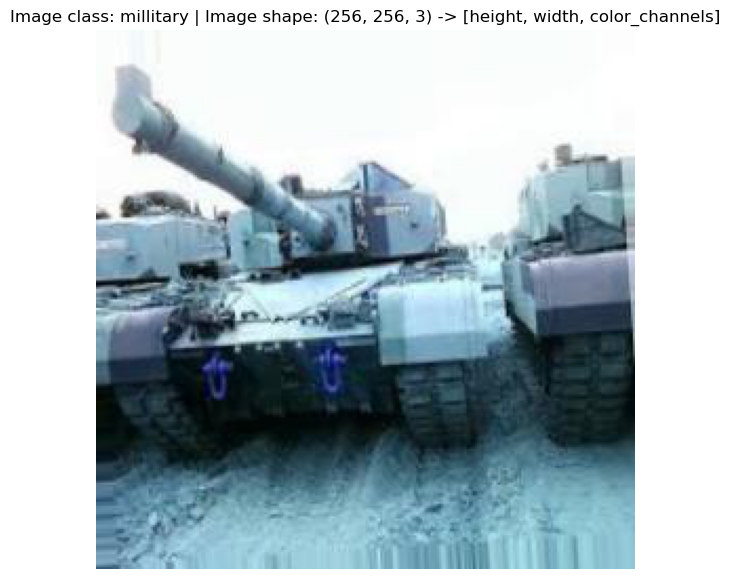

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

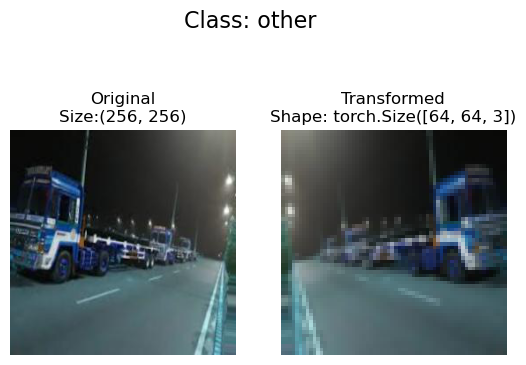

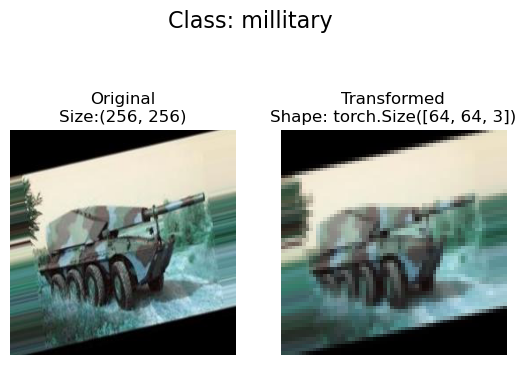

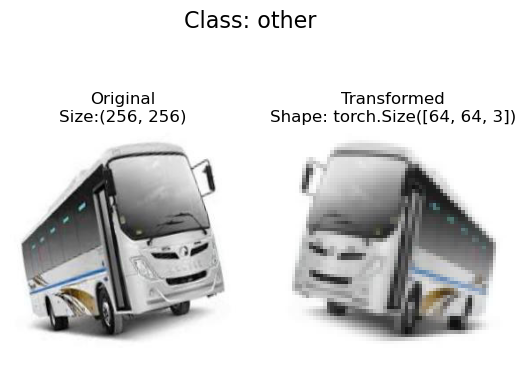

In [7]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [8]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [9]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [10]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [11]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2449aac9670>,
 <torch.utils.data.dataloader.DataLoader at 0x24486f8efa0>)

In [12]:
from helper_functions import set_seeds
set_seeds()

class MilitaryNormalClassModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [13]:
model_0=MilitaryNormalClassModel(input_shape=3,
                                 hidden_units=30,
                                 output_shape=len(classes)).to(device)

In [14]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time, test_step, train_step 

from timeit import default_timer as timer


train_time_start_model_0=timer()

epochs=100

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_0,
                                          end=train_time_end_model_0,
                                          device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.68842 | Train acc: 54.08%


  1%|          | 1/100 [00:53<1:28:52, 53.86s/it]


Test loss: 0.6871, Test acc 54.2556
Epoch: 2
-------------
Train loss: 0.68649 | Train acc: 54.08%


  2%|▏         | 2/100 [01:40<1:20:40, 49.39s/it]


Test loss: 0.6853, Test acc 54.1084
Epoch: 3
-------------
Train loss: 0.68271 | Train acc: 54.01%


  3%|▎         | 3/100 [02:26<1:17:49, 48.14s/it]


Test loss: 0.6797, Test acc 56.1884
Epoch: 4
-------------
Train loss: 0.67206 | Train acc: 56.87%


  4%|▍         | 4/100 [03:14<1:17:03, 48.16s/it]


Test loss: 0.6718, Test acc 54.6233
Epoch: 5
-------------
Train loss: 0.65573 | Train acc: 61.34%


  5%|▌         | 5/100 [04:02<1:15:39, 47.79s/it]


Test loss: 0.6479, Test acc 62.6541
Epoch: 6
-------------
Train loss: 0.64534 | Train acc: 63.46%


  6%|▌         | 6/100 [04:51<1:15:42, 48.32s/it]


Test loss: 0.6550, Test acc 61.5240
Epoch: 7
-------------
Train loss: 0.63502 | Train acc: 64.60%


  7%|▋         | 7/100 [05:40<1:15:12, 48.52s/it]


Test loss: 0.6272, Test acc 65.7545
Epoch: 8
-------------
Train loss: 0.62354 | Train acc: 65.83%


  8%|▊         | 8/100 [06:26<1:13:13, 47.76s/it]


Test loss: 0.6114, Test acc 67.5081
Epoch: 9
-------------
Train loss: 0.60307 | Train acc: 68.37%


  9%|▉         | 9/100 [07:12<1:11:29, 47.13s/it]


Test loss: 0.6036, Test acc 68.4220
Epoch: 10
-------------
Train loss: 0.58351 | Train acc: 70.22%


 10%|█         | 10/100 [07:57<1:10:00, 46.67s/it]


Test loss: 0.7075, Test acc 54.1000
Epoch: 11
-------------
Train loss: 0.53919 | Train acc: 73.14%


 11%|█         | 11/100 [08:43<1:08:47, 46.38s/it]


Test loss: 0.5135, Test acc 75.9693
Epoch: 12
-------------
Train loss: 0.51005 | Train acc: 74.91%


 12%|█▏        | 12/100 [09:29<1:07:47, 46.22s/it]


Test loss: 0.4942, Test acc 76.6105
Epoch: 13
-------------
Train loss: 0.49604 | Train acc: 76.06%


 13%|█▎        | 13/100 [10:16<1:07:12, 46.35s/it]


Test loss: 0.5159, Test acc 73.6292
Epoch: 14
-------------
Train loss: 0.49195 | Train acc: 76.29%


 14%|█▍        | 14/100 [11:04<1:07:13, 46.90s/it]


Test loss: 0.4856, Test acc 77.2607
Epoch: 15
-------------
Train loss: 0.48368 | Train acc: 76.76%


 15%|█▌        | 15/100 [11:51<1:06:24, 46.87s/it]


Test loss: 0.4962, Test acc 76.9876
Epoch: 16
-------------
Train loss: 0.48521 | Train acc: 76.38%


 16%|█▌        | 16/100 [12:37<1:05:28, 46.77s/it]


Test loss: 0.5549, Test acc 71.0567
Epoch: 17
-------------
Train loss: 0.47270 | Train acc: 77.82%


 17%|█▋        | 17/100 [13:24<1:04:42, 46.77s/it]


Test loss: 0.5233, Test acc 74.7128
Epoch: 18
-------------
Train loss: 0.46987 | Train acc: 78.06%


 18%|█▊        | 18/100 [14:11<1:04:01, 46.85s/it]


Test loss: 0.4453, Test acc 79.7820
Epoch: 19
-------------
Train loss: 0.46832 | Train acc: 77.77%


 19%|█▉        | 19/100 [14:57<1:02:54, 46.60s/it]


Test loss: 0.4564, Test acc 78.4300
Epoch: 20
-------------
Train loss: 0.46666 | Train acc: 78.49%


 20%|██        | 20/100 [15:42<1:01:38, 46.23s/it]


Test loss: 0.4931, Test acc 76.0554
Epoch: 21
-------------
Train loss: 0.45559 | Train acc: 78.80%


 21%|██        | 21/100 [16:28<1:00:33, 45.99s/it]


Test loss: 0.4331, Test acc 80.7868
Epoch: 22
-------------
Train loss: 0.45551 | Train acc: 78.59%


 22%|██▏       | 22/100 [17:13<59:35, 45.84s/it]  


Test loss: 0.4884, Test acc 75.5979
Epoch: 23
-------------
Train loss: 0.45294 | Train acc: 79.37%


 23%|██▎       | 23/100 [17:59<58:44, 45.77s/it]


Test loss: 0.4251, Test acc 81.2625
Epoch: 24
-------------
Train loss: 0.44181 | Train acc: 79.72%


 24%|██▍       | 24/100 [18:46<58:36, 46.27s/it]


Test loss: 0.4464, Test acc 80.5142
Epoch: 25
-------------
Train loss: 0.44394 | Train acc: 79.73%


 25%|██▌       | 25/100 [19:34<58:25, 46.74s/it]


Test loss: 0.4323, Test acc 80.3434
Epoch: 26
-------------
Train loss: 0.43399 | Train acc: 80.48%


 26%|██▌       | 26/100 [20:22<58:00, 47.03s/it]


Test loss: 0.4375, Test acc 80.1747
Epoch: 27
-------------
Train loss: 0.44469 | Train acc: 79.30%


 27%|██▋       | 27/100 [21:09<57:26, 47.21s/it]


Test loss: 0.4425, Test acc 78.6347
Epoch: 28
-------------
Train loss: 0.42797 | Train acc: 80.59%


 28%|██▊       | 28/100 [21:57<56:43, 47.28s/it]


Test loss: 0.4275, Test acc 80.1711
Epoch: 29
-------------
Train loss: 0.42875 | Train acc: 80.20%


 29%|██▉       | 29/100 [22:44<55:52, 47.22s/it]


Test loss: 0.4160, Test acc 81.0829
Epoch: 30
-------------
Train loss: 0.42013 | Train acc: 81.20%


 30%|███       | 30/100 [23:30<54:33, 46.76s/it]


Test loss: 0.4234, Test acc 80.3920
Epoch: 31
-------------
Train loss: 0.42474 | Train acc: 80.70%


 31%|███       | 31/100 [24:15<53:20, 46.38s/it]


Test loss: 0.6340, Test acc 67.0021
Epoch: 32
-------------
Train loss: 0.42620 | Train acc: 80.41%


 32%|███▏      | 32/100 [25:01<52:16, 46.13s/it]


Test loss: 0.3985, Test acc 82.6987
Epoch: 33
-------------
Train loss: 0.41652 | Train acc: 81.15%


 33%|███▎      | 33/100 [25:46<51:17, 45.93s/it]


Test loss: 0.4126, Test acc 81.3759
Epoch: 34
-------------
Train loss: 0.40920 | Train acc: 81.77%


 34%|███▍      | 34/100 [26:31<50:19, 45.75s/it]


Test loss: 0.4035, Test acc 82.2965
Epoch: 35
-------------
Train loss: 0.40997 | Train acc: 81.53%


 35%|███▌      | 35/100 [27:17<49:28, 45.66s/it]


Test loss: 0.4692, Test acc 76.0512
Epoch: 36
-------------
Train loss: 0.40686 | Train acc: 81.70%


 36%|███▌      | 36/100 [28:02<48:37, 45.58s/it]


Test loss: 0.4769, Test acc 76.3750
Epoch: 37
-------------
Train loss: 0.39969 | Train acc: 82.23%


 37%|███▋      | 37/100 [28:48<47:45, 45.48s/it]


Test loss: 0.4216, Test acc 81.3007
Epoch: 38
-------------
Train loss: 0.39931 | Train acc: 82.24%


 38%|███▊      | 38/100 [29:33<47:03, 45.53s/it]


Test loss: 0.4086, Test acc 82.2370
Epoch: 39
-------------
Train loss: 0.39721 | Train acc: 81.88%


 39%|███▉      | 39/100 [30:19<46:17, 45.53s/it]


Test loss: 0.5235, Test acc 72.6552
Epoch: 40
-------------
Train loss: 0.39831 | Train acc: 82.14%


 40%|████      | 40/100 [31:04<45:29, 45.50s/it]


Test loss: 0.4114, Test acc 81.4359
Epoch: 41
-------------
Train loss: 0.38803 | Train acc: 82.88%


 41%|████      | 41/100 [31:50<44:49, 45.59s/it]


Test loss: 0.3792, Test acc 82.9561
Epoch: 42
-------------
Train loss: 0.38401 | Train acc: 83.22%


 42%|████▏     | 42/100 [32:36<44:02, 45.57s/it]


Test loss: 0.3772, Test acc 83.1775
Epoch: 43
-------------
Train loss: 0.38643 | Train acc: 82.73%


 43%|████▎     | 43/100 [33:21<43:16, 45.56s/it]


Test loss: 0.4992, Test acc 75.7426
Epoch: 44
-------------
Train loss: 0.37820 | Train acc: 83.16%


 44%|████▍     | 44/100 [34:07<42:29, 45.53s/it]


Test loss: 0.4848, Test acc 75.3410
Epoch: 45
-------------
Train loss: 0.37939 | Train acc: 83.19%


 45%|████▌     | 45/100 [34:52<41:46, 45.57s/it]


Test loss: 0.6665, Test acc 68.0518
Epoch: 46
-------------
Train loss: 0.38361 | Train acc: 83.17%


 46%|████▌     | 46/100 [35:38<41:01, 45.58s/it]


Test loss: 0.3576, Test acc 84.5849
Epoch: 47
-------------
Train loss: 0.37111 | Train acc: 83.60%


 47%|████▋     | 47/100 [36:23<40:14, 45.56s/it]


Test loss: 0.3604, Test acc 84.3055
Epoch: 48
-------------
Train loss: 0.36873 | Train acc: 83.72%


 48%|████▊     | 48/100 [37:09<39:29, 45.56s/it]


Test loss: 0.3563, Test acc 84.6184
Epoch: 49
-------------
Train loss: 0.36953 | Train acc: 83.75%


 49%|████▉     | 49/100 [37:54<38:41, 45.52s/it]


Test loss: 0.4076, Test acc 81.5774
Epoch: 50
-------------
Train loss: 0.36367 | Train acc: 83.80%


 50%|█████     | 50/100 [38:40<37:53, 45.47s/it]


Test loss: 0.3537, Test acc 84.5562
Epoch: 51
-------------
Train loss: 0.36478 | Train acc: 84.17%


 51%|█████     | 51/100 [39:25<37:10, 45.53s/it]


Test loss: 0.3805, Test acc 82.4872
Epoch: 52
-------------
Train loss: 0.36682 | Train acc: 83.51%


 52%|█████▏    | 52/100 [40:11<36:28, 45.60s/it]


Test loss: 0.3465, Test acc 84.8408
Epoch: 53
-------------
Train loss: 0.36454 | Train acc: 83.69%


 53%|█████▎    | 53/100 [40:57<35:41, 45.57s/it]


Test loss: 0.3548, Test acc 84.4784
Epoch: 54
-------------
Train loss: 0.35848 | Train acc: 84.38%


 54%|█████▍    | 54/100 [41:42<34:57, 45.60s/it]


Test loss: 0.3682, Test acc 82.9091
Epoch: 55
-------------
Train loss: 0.35760 | Train acc: 84.44%


 55%|█████▌    | 55/100 [42:28<34:11, 45.60s/it]


Test loss: 0.3501, Test acc 84.9823
Epoch: 56
-------------
Train loss: 0.35541 | Train acc: 84.46%


 56%|█████▌    | 56/100 [43:13<33:27, 45.62s/it]


Test loss: 0.3940, Test acc 81.1873
Epoch: 57
-------------
Train loss: 0.36040 | Train acc: 83.79%


 57%|█████▋    | 57/100 [43:59<32:43, 45.66s/it]


Test loss: 0.6090, Test acc 69.5939
Epoch: 58
-------------
Train loss: 0.35251 | Train acc: 84.61%


 58%|█████▊    | 58/100 [44:45<32:02, 45.76s/it]


Test loss: 0.3572, Test acc 84.7317
Epoch: 59
-------------
Train loss: 0.35015 | Train acc: 84.81%


 59%|█████▉    | 59/100 [45:31<31:19, 45.85s/it]


Test loss: 0.3546, Test acc 84.7583
Epoch: 60
-------------
Train loss: 0.34991 | Train acc: 84.67%


 60%|██████    | 60/100 [46:17<30:26, 45.67s/it]


Test loss: 0.3484, Test acc 85.2623
Epoch: 61
-------------
Train loss: 0.35143 | Train acc: 84.50%


 61%|██████    | 61/100 [47:02<29:39, 45.62s/it]


Test loss: 0.4436, Test acc 77.9689
Epoch: 62
-------------
Train loss: 0.34856 | Train acc: 84.56%


 62%|██████▏   | 62/100 [47:47<28:51, 45.56s/it]


Test loss: 0.3345, Test acc 85.6727
Epoch: 63
-------------
Train loss: 0.34236 | Train acc: 85.43%


 63%|██████▎   | 63/100 [48:33<28:03, 45.50s/it]


Test loss: 0.3750, Test acc 83.3582
Epoch: 64
-------------
Train loss: 0.34232 | Train acc: 85.03%


 64%|██████▍   | 64/100 [49:18<27:17, 45.49s/it]


Test loss: 0.3301, Test acc 85.6571
Epoch: 65
-------------
Train loss: 0.34105 | Train acc: 85.17%


 65%|██████▌   | 65/100 [50:04<26:32, 45.51s/it]


Test loss: 0.4274, Test acc 79.2520
Epoch: 66
-------------
Train loss: 0.34146 | Train acc: 85.14%


 66%|██████▌   | 66/100 [50:49<25:45, 45.46s/it]


Test loss: 0.4169, Test acc 80.9858
Epoch: 67
-------------
Train loss: 0.33792 | Train acc: 85.19%


 67%|██████▋   | 67/100 [51:35<25:00, 45.48s/it]


Test loss: 0.3728, Test acc 82.3059
Epoch: 68
-------------
Train loss: 0.34089 | Train acc: 85.09%


 68%|██████▊   | 68/100 [52:20<24:14, 45.45s/it]


Test loss: 0.3725, Test acc 82.6167
Epoch: 69
-------------
Train loss: 0.33740 | Train acc: 85.40%


 69%|██████▉   | 69/100 [53:06<23:28, 45.44s/it]


Test loss: 0.3769, Test acc 81.8662
Epoch: 70
-------------
Train loss: 0.33244 | Train acc: 85.68%


 70%|███████   | 70/100 [53:51<22:43, 45.46s/it]


Test loss: 0.5702, Test acc 72.3560
Epoch: 71
-------------
Train loss: 0.33308 | Train acc: 85.45%


 71%|███████   | 71/100 [54:38<22:14, 46.02s/it]


Test loss: 0.3233, Test acc 86.1610
Epoch: 72
-------------
Train loss: 0.32500 | Train acc: 85.94%


 72%|███████▏  | 72/100 [55:25<21:30, 46.08s/it]


Test loss: 0.4032, Test acc 81.4934
Epoch: 73
-------------
Train loss: 0.33620 | Train acc: 85.27%


 73%|███████▎  | 73/100 [56:11<20:44, 46.10s/it]


Test loss: 0.3287, Test acc 86.1542
Epoch: 74
-------------
Train loss: 0.33052 | Train acc: 85.66%


 74%|███████▍  | 74/100 [57:00<20:24, 47.10s/it]


Test loss: 0.3467, Test acc 84.9714
Epoch: 75
-------------
Train loss: 0.33383 | Train acc: 85.53%


 75%|███████▌  | 75/100 [57:46<19:26, 46.66s/it]


Test loss: 0.3405, Test acc 84.6873
Epoch: 76
-------------
Train loss: 0.32737 | Train acc: 85.99%


 76%|███████▌  | 76/100 [58:31<18:32, 46.35s/it]


Test loss: 0.3119, Test acc 86.5119
Epoch: 77
-------------
Train loss: 0.32821 | Train acc: 86.32%


 77%|███████▋  | 77/100 [59:17<17:40, 46.12s/it]


Test loss: 0.3323, Test acc 85.9234
Epoch: 78
-------------
Train loss: 0.32731 | Train acc: 86.02%


 78%|███████▊  | 78/100 [1:00:03<16:55, 46.15s/it]


Test loss: 0.3212, Test acc 85.8148
Epoch: 79
-------------
Train loss: 0.32451 | Train acc: 86.11%


 79%|███████▉  | 79/100 [1:00:49<16:06, 46.01s/it]


Test loss: 0.3815, Test acc 81.4730
Epoch: 80
-------------
Train loss: 0.32375 | Train acc: 85.85%


 80%|████████  | 80/100 [1:01:35<15:18, 45.93s/it]


Test loss: 0.3159, Test acc 86.4984
Epoch: 81
-------------
Train loss: 0.32479 | Train acc: 85.99%


 81%|████████  | 81/100 [1:02:24<14:54, 47.10s/it]


Test loss: 0.3168, Test acc 86.2566
Epoch: 82
-------------
Train loss: 0.32185 | Train acc: 86.14%


 82%|████████▏ | 82/100 [1:03:13<14:17, 47.65s/it]


Test loss: 0.3263, Test acc 86.1652
Epoch: 83
-------------
Train loss: 0.31402 | Train acc: 86.81%


 83%|████████▎ | 83/100 [1:04:03<13:39, 48.20s/it]


Test loss: 0.3080, Test acc 86.8002
Epoch: 84
-------------
Train loss: 0.31739 | Train acc: 86.12%


 84%|████████▍ | 84/100 [1:04:52<12:55, 48.48s/it]


Test loss: 0.3948, Test acc 82.1326
Epoch: 85
-------------
Train loss: 0.32224 | Train acc: 86.01%


 85%|████████▌ | 85/100 [1:05:41<12:10, 48.72s/it]


Test loss: 0.3227, Test acc 86.3897
Epoch: 86
-------------
Train loss: 0.31327 | Train acc: 86.67%


 86%|████████▌ | 86/100 [1:06:30<11:20, 48.58s/it]


Test loss: 0.3569, Test acc 83.7306
Epoch: 87
-------------
Train loss: 0.31521 | Train acc: 86.40%


 87%|████████▋ | 87/100 [1:07:17<10:28, 48.32s/it]


Test loss: 0.3220, Test acc 86.2101
Epoch: 88
-------------
Train loss: 0.31383 | Train acc: 86.68%


 88%|████████▊ | 88/100 [1:08:05<09:38, 48.17s/it]


Test loss: 0.3182, Test acc 86.2811
Epoch: 89
-------------
Train loss: 0.31257 | Train acc: 86.48%


 89%|████████▉ | 89/100 [1:08:53<08:49, 48.15s/it]


Test loss: 0.3206, Test acc 86.6054
Epoch: 90
-------------
Train loss: 0.31112 | Train acc: 86.87%


 90%|█████████ | 90/100 [1:09:42<08:03, 48.37s/it]


Test loss: 0.3144, Test acc 85.9636
Epoch: 91
-------------
Train loss: 0.31159 | Train acc: 86.60%


 91%|█████████ | 91/100 [1:10:30<07:13, 48.15s/it]


Test loss: 0.3835, Test acc 81.5357
Epoch: 92
-------------
Train loss: 0.30867 | Train acc: 86.73%


 92%|█████████▏| 92/100 [1:11:19<06:26, 48.35s/it]


Test loss: 0.4227, Test acc 79.9554
Epoch: 93
-------------
Train loss: 0.31351 | Train acc: 86.51%


 93%|█████████▎| 93/100 [1:12:08<05:41, 48.77s/it]


Test loss: 0.3011, Test acc 87.2065
Epoch: 94
-------------
Train loss: 0.30701 | Train acc: 86.86%


 94%|█████████▍| 94/100 [1:12:57<04:53, 48.90s/it]


Test loss: 0.3046, Test acc 86.6493
Epoch: 95
-------------
Train loss: 0.31003 | Train acc: 86.73%


 95%|█████████▌| 95/100 [1:13:48<04:06, 49.32s/it]


Test loss: 0.3056, Test acc 87.0953
Epoch: 96
-------------
Train loss: 0.30235 | Train acc: 87.38%


 96%|█████████▌| 96/100 [1:14:38<03:18, 49.54s/it]


Test loss: 0.3002, Test acc 87.2060
Epoch: 97
-------------
Train loss: 0.30405 | Train acc: 87.15%


 97%|█████████▋| 97/100 [1:15:29<02:29, 49.97s/it]


Test loss: 0.3070, Test acc 87.2352
Epoch: 98
-------------
Train loss: 0.30205 | Train acc: 87.53%


 98%|█████████▊| 98/100 [1:16:18<01:39, 49.66s/it]


Test loss: 0.3258, Test acc 85.0779
Epoch: 99
-------------
Train loss: 0.30469 | Train acc: 87.08%


 99%|█████████▉| 99/100 [1:17:03<00:48, 48.43s/it]


Test loss: 0.3460, Test acc 84.1593
Epoch: 100
-------------
Train loss: 0.30234 | Train acc: 87.13%


100%|██████████| 100/100 [1:17:49<00:00, 46.69s/it]


Test loss: 0.2947, Test acc 87.1068

Train time on cuda: 4669.509 seconds


In [16]:
from helper_functions import eval_model


model_0_results=eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


{'model_name': 'MilitaryNormalClassModel',
 'model_loss': 0.31398504972457886,
 'model_acc': 86.05222902097903}

In [19]:
def make_predictions(model:torch.nn.Module,
                     data: list,
                     device:torch.device=device):
    pred_probs= []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample,dim=0).to(device)

            #Forward pass (model outputs raw logits)
            pred_logit=model(sample)

            #Get pred probs(logit to pred probs)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)

            #Turn pred probs in to prediction labels(targets)
            
            #Get pred_prob off the GPU for futher calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

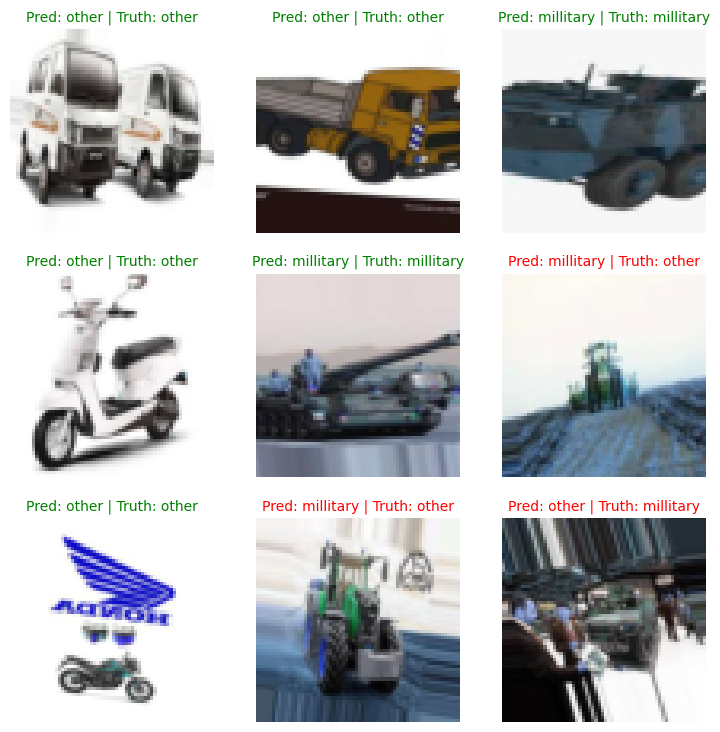

In [33]:

import random
#random.seed(42)

test_samples=[]
test_labels=[]

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

#View the first sample shape
test_samples[0].shape

pred_probs=make_predictions(model=model_0,
                            data=test_samples,
                            device=device)


pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(np.transpose(sample, (1, 2, 0)), cmap="gray")


  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="green") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="red") # red text if wrong
  plt.axis(False)

In [31]:
model_0_results

{'model_name': 'MilitaryNormalClassModel',
 'model_loss': 0.31398504972457886,
 'model_acc': 86.05222902097903}

Making predictions: 100%|██████████| 22/22 [00:45<00:00,  2.06s/it]


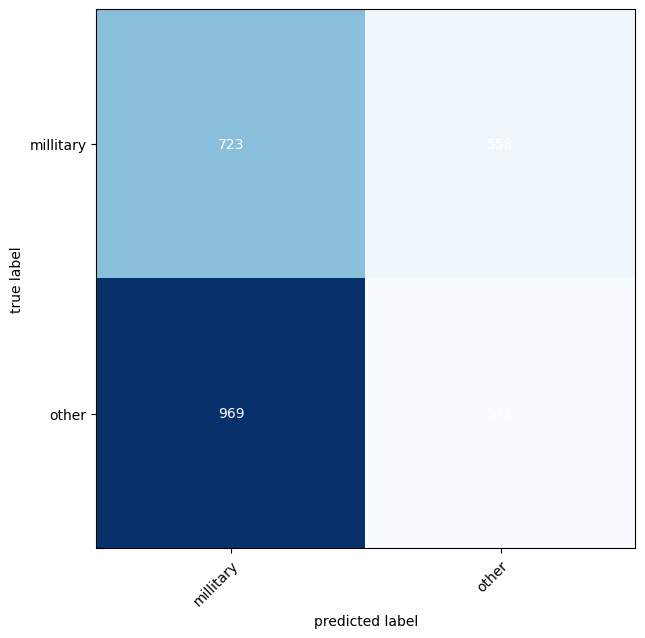

In [37]:
from tqdm.auto import tqdm

# Make preds with trained model

y_preds=[]

model_0.eval()
 
with torch.inference_mode():
    for X,y in tqdm(test_dataloader,desc="Making predictions"):
        #Send the data and tarets to target device
        X,y=X.to(device),y.to(device)

        y_logit = model_0(X)

        y_pred=torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)

        #Put predictions on CPU for evaluation

        y_preds.append(y_pred.cpu())


y_pred_tensor=torch.cat(y_preds)
import torchmetrics,mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets

confmat = ConfusionMatrix(task="multiclass",num_classes=len(classes))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# Plot the confusion matrix

fig,ax=plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes,
    figsize=(10,7)
)

In [44]:
from pathlib import Path 
import torch
#Create a model directory

MODEL_PATH =Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

#Create a model save path
MODEL_NAME="military_normal_classifier_model_0.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

#Save the model state dict

print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\military_normal_classifier_model_0.pth


In [45]:
#Create a new instance of our model

torch.manual_seed(42)

loaded_model_0=MilitaryNormalClassModel(input_shape=3,
                                   hidden_units=30,
                                   output_shape=len(classes))

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Send the model to target device

loaded_model_0.to(device)

MilitaryNormalClassModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7680, out_features=2, bias=True)
  )
)

In [46]:
#Evaluate loaded model
torch.manual_seed(42)

loaded_model_0_results=eval_model(
    model=loaded_model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
loaded_model_0_results

100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


{'model_name': 'MilitaryNormalClassModel',
 'model_loss': 0.3153935968875885,
 'model_acc': 85.87467220279721}

In [47]:
#Check if model results are close to each
torch.isclose(torch.tensor(model_0_results["model_loss"]),
              torch.tensor(loaded_model_0_results["model_loss"]),
              atol=1e-04)#atol = tolerance level (decimal point)

tensor(False)